### Ньяти Каелиле БВТ2201 - Курсовая Работа

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import make_grid

### Generative Adversarial Network (GAN)

In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
learning_rate = 0.0002
epochs = 50
latent_dim = 100


Using device: cpu


In [6]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights and bias
        # Using Kaiming uniform initialization (similar to nn.Linear)
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        # Kaiming uniform initialization
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        # y = xW^T + b
        return torch.matmul(x, self.weight.t()) + (self.bias if self.bias is not None else 0)
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [7]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim, device=device)

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: latent_dim
            CustomLinear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            CustomLinear(256, 512),
            nn.LeakyReLU(0.2),
            CustomLinear(512, 1024),
            nn.LeakyReLU(0.2),
            CustomLinear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1, 28, 28)

In [8]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: 784 (28x28)
            CustomLinear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            CustomLinear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            CustomLinear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            CustomLinear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Initialize networks
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [9]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Two optimizers - one for generator, one for discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Lists to track progress
G_losses = []
D_losses = []
D_real_losses = []
D_fake_losses = []

# Training function
def train_gan(epoch):
    generator.train()
    discriminator.train()
    
    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size = real_imgs.size(0)
        
        # Move real images to device
        real_imgs = real_imgs.to(device)
        
        # Create labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        # ========================
        #  Train Discriminator
        # ========================
        
        optimizer_D.zero_grad()
        
        # Loss with real images
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)
        
        # Generate fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(noise)
        
        # Loss with fake images
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # ========================
        #  Train Generator
        # ========================
        
        optimizer_G.zero_grad()
        
        # Generate new fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(noise)
        
        # Generator wants discriminator to think fake images are real
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Save losses for plotting
        if i % 50 == 0:
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            D_real_losses.append(d_loss_real.item())
            D_fake_losses.append(d_loss_fake.item())
        
        if i % 100 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(train_loader)}] '
                  f'D_loss: {d_loss.item():.4f} '
                  f'G_loss: {g_loss.item():.4f} '
                  f'D(x): {real_output.mean().item():.4f} '
                  f'D(G(z)): {fake_output.mean().item():.4f}')

In [10]:
# Function to generate and save images
def generate_images(epoch):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        
        # Denormalize from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2
        
        # Create grid of images
        grid = make_grid(fake_images, nrow=8, normalize=True)
        
        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.title(f'Generated Images - Epoch {epoch}')
        plt.axis('off')
        plt.show()
        
        return grid

# Function to show training progress
def plot_training_progress():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(G_losses, label='Generator Loss')
    ax1.plot(D_losses, label='Discriminator Loss')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title('Generator and Discriminator Losses')
    ax1.legend()
    ax1.grid(True)
    
    # Plot discriminator components
    ax2.plot(D_real_losses, label='D Real Loss', alpha=0.7)
    ax2.plot(D_fake_losses, label='D Fake Loss', alpha=0.7)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title('Discriminator Real vs Fake Losses')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [11]:
# Function to show real vs fake comparison
def show_real_vs_fake():
    # Get some real images
    real_imgs, _ = next(iter(train_loader))
    real_imgs = real_imgs[:32]
    
    # Generate fake images
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(32, latent_dim, device=device)
        fake_imgs = generator(noise).detach().cpu()
    
    # Denormalize
    real_imgs = (real_imgs + 1) / 2
    fake_imgs = (fake_imgs + 1) / 2
    
    # Create grids
    real_grid = make_grid(real_imgs, nrow=8, normalize=False)
    fake_grid = make_grid(fake_imgs, nrow=8, normalize=False)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(real_grid.permute(1, 2, 0), cmap='gray')
    ax1.set_title('Real MNIST Images')
    ax1.axis('off')
    
    ax2.imshow(fake_grid.permute(1, 2, 0), cmap='gray')
    ax2.set_title('Generated Images')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to show interpolation in latent space
def show_latent_interpolation():
    generator.eval()
    with torch.no_grad():
        # Create two random points in latent space
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)
        
        # Interpolate between them
        num_steps = 10
        interpolated = []
        
        for alpha in torch.linspace(0, 1, num_steps):
            z = alpha * z1 + (1 - alpha) * z2
            img = generator(z).detach().cpu()
            interpolated.append(img)
        
        # Create grid
        interpolated = torch.cat(interpolated, 0)
        interpolated = (interpolated + 1) / 2  # Denormalize
        grid = make_grid(interpolated, nrow=num_steps, normalize=False)
        
        # Plot
        plt.figure(figsize=(12, 2))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.title('Latent Space Interpolation')
        plt.axis('off')
        plt.show()



Starting GAN training...
Generator architecture:
Generator(
  (main): Sequential(
    (0): CustomLinear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): CustomLinear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): CustomLinear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): CustomLinear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Discriminator architecture:
Discriminator(
  (main): Sequential(
    (0): CustomLinear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): CustomLinear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): CustomLinear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)

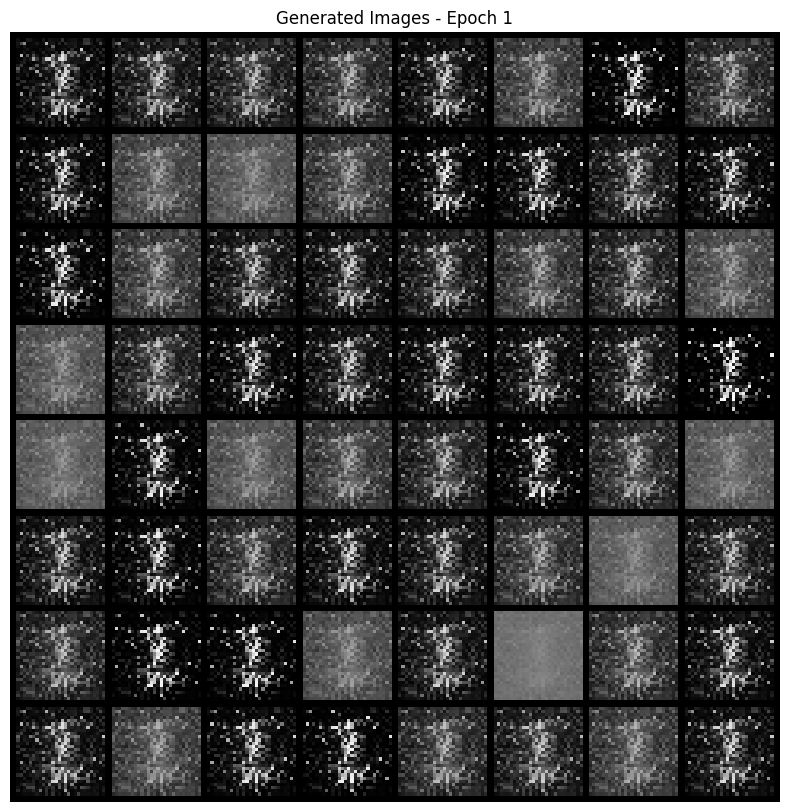

[2/50][0/469] D_loss: 0.2079 G_loss: 4.2265 D(x): 0.9001 D(G(z)): 0.0210
[2/50][100/469] D_loss: 0.3009 G_loss: 8.0014 D(x): 0.9667 D(G(z)): 0.0007
[2/50][200/469] D_loss: 0.2959 G_loss: 2.9368 D(x): 0.8202 D(G(z)): 0.0690
[2/50][300/469] D_loss: 0.3548 G_loss: 2.6013 D(x): 0.8091 D(G(z)): 0.0920
[2/50][400/469] D_loss: 0.8647 G_loss: 0.6748 D(x): 0.6471 D(G(z)): 0.5599
[3/50][0/469] D_loss: 0.4387 G_loss: 5.7505 D(x): 0.9114 D(G(z)): 0.0062
[3/50][100/469] D_loss: 0.1813 G_loss: 3.8425 D(x): 0.9170 D(G(z)): 0.0381
[3/50][200/469] D_loss: 0.2884 G_loss: 3.2975 D(x): 0.9109 D(G(z)): 0.0575
[3/50][300/469] D_loss: 0.2527 G_loss: 2.7134 D(x): 0.9278 D(G(z)): 0.0975
[3/50][400/469] D_loss: 0.5910 G_loss: 3.8671 D(x): 0.9576 D(G(z)): 0.0344
[4/50][0/469] D_loss: 0.6574 G_loss: 3.6150 D(x): 0.9066 D(G(z)): 0.0437
[4/50][100/469] D_loss: 0.4488 G_loss: 2.5954 D(x): 0.8671 D(G(z)): 0.1010
[4/50][200/469] D_loss: 0.3544 G_loss: 3.2451 D(x): 0.8823 D(G(z)): 0.0570
[4/50][300/469] D_loss: 0.3765 

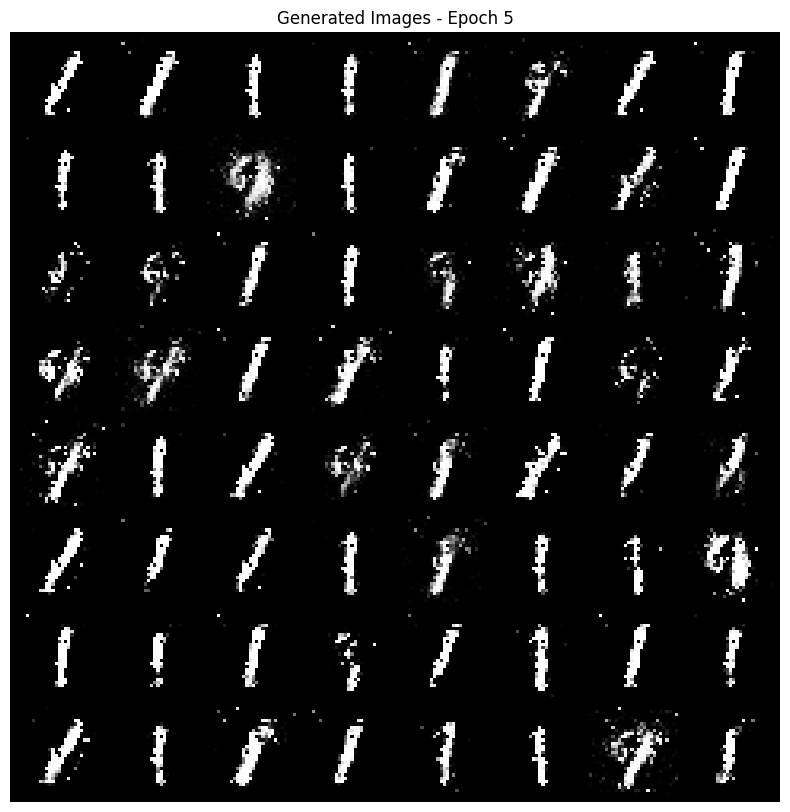

[6/50][0/469] D_loss: 0.4081 G_loss: 2.5080 D(x): 0.9130 D(G(z)): 0.1108
[6/50][100/469] D_loss: 0.5866 G_loss: 4.0018 D(x): 0.7936 D(G(z)): 0.0242
[6/50][200/469] D_loss: 0.3339 G_loss: 2.7248 D(x): 0.9015 D(G(z)): 0.0907
[6/50][300/469] D_loss: 0.3472 G_loss: 3.5391 D(x): 0.9328 D(G(z)): 0.0391
[6/50][400/469] D_loss: 0.3415 G_loss: 3.5608 D(x): 0.9305 D(G(z)): 0.0407
[7/50][0/469] D_loss: 0.4760 G_loss: 2.3419 D(x): 0.8676 D(G(z)): 0.1318
[7/50][100/469] D_loss: 0.3076 G_loss: 2.6564 D(x): 0.8879 D(G(z)): 0.1017
[7/50][200/469] D_loss: 0.3152 G_loss: 2.1470 D(x): 0.8908 D(G(z)): 0.1539
[7/50][300/469] D_loss: 0.4557 G_loss: 2.4885 D(x): 0.8855 D(G(z)): 0.1051
[7/50][400/469] D_loss: 1.2322 G_loss: 2.0569 D(x): 0.5903 D(G(z)): 0.2065
[8/50][0/469] D_loss: 0.5035 G_loss: 2.1428 D(x): 0.8354 D(G(z)): 0.1372
[8/50][100/469] D_loss: 0.5968 G_loss: 1.9138 D(x): 0.7939 D(G(z)): 0.1849
[8/50][200/469] D_loss: 0.5015 G_loss: 1.5177 D(x): 0.8092 D(G(z)): 0.2843
[8/50][300/469] D_loss: 0.6787 

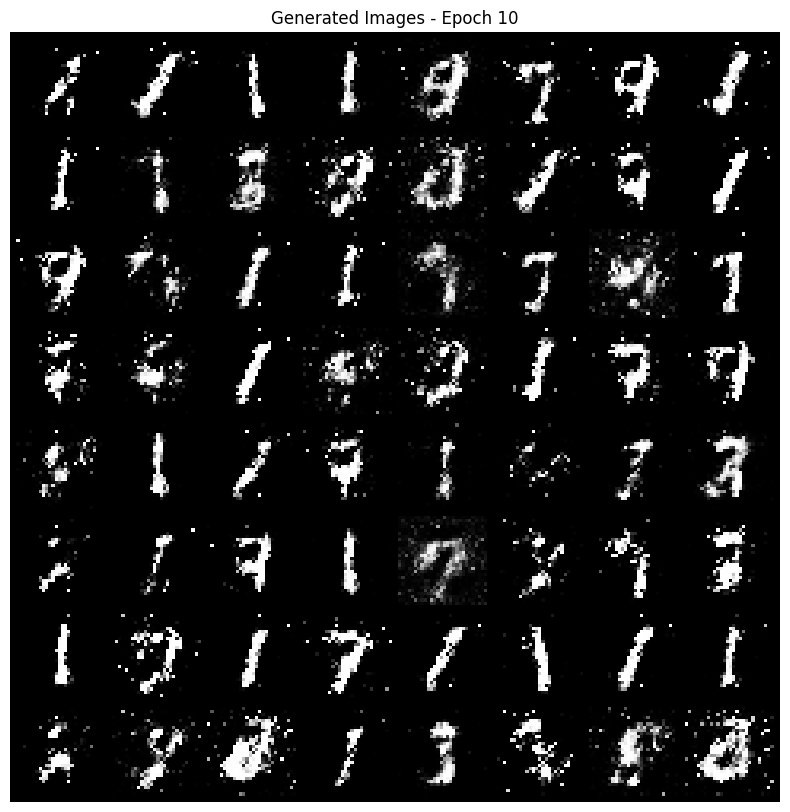

[11/50][0/469] D_loss: 0.8580 G_loss: 1.1615 D(x): 0.5962 D(G(z)): 0.3728
[11/50][100/469] D_loss: 0.5561 G_loss: 1.6632 D(x): 0.7894 D(G(z)): 0.2238
[11/50][200/469] D_loss: 0.7246 G_loss: 1.8476 D(x): 0.7943 D(G(z)): 0.1814
[11/50][300/469] D_loss: 0.7031 G_loss: 1.4660 D(x): 0.7654 D(G(z)): 0.2689
[11/50][400/469] D_loss: 0.9435 G_loss: 2.4756 D(x): 0.8034 D(G(z)): 0.1020
[12/50][0/469] D_loss: 2.2786 G_loss: 2.0101 D(x): 0.2609 D(G(z)): 0.1605
[12/50][100/469] D_loss: 0.8510 G_loss: 1.7157 D(x): 0.7168 D(G(z)): 0.2305
[12/50][200/469] D_loss: 0.7386 G_loss: 1.5612 D(x): 0.7641 D(G(z)): 0.2558
[12/50][300/469] D_loss: 0.8314 G_loss: 1.9845 D(x): 0.7763 D(G(z)): 0.1720
[12/50][400/469] D_loss: 0.8476 G_loss: 2.3906 D(x): 0.8229 D(G(z)): 0.1143
[13/50][0/469] D_loss: 0.8605 G_loss: 1.4785 D(x): 0.6499 D(G(z)): 0.2776
[13/50][100/469] D_loss: 0.9372 G_loss: 1.9297 D(x): 0.8476 D(G(z)): 0.1790
[13/50][200/469] D_loss: 0.8406 G_loss: 1.5753 D(x): 0.7252 D(G(z)): 0.2727
[13/50][300/469] D

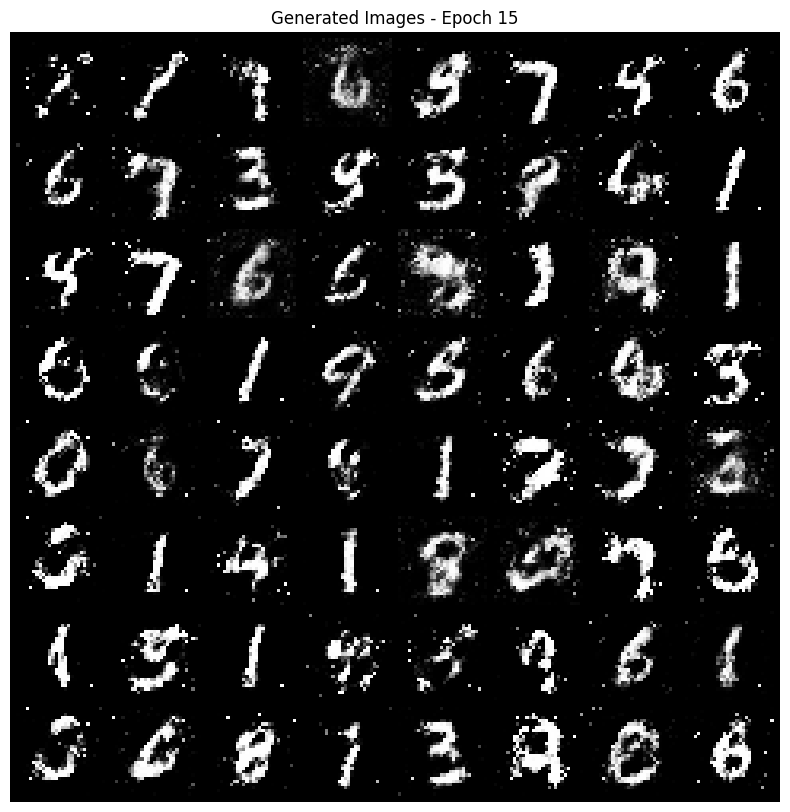

[16/50][0/469] D_loss: 0.9754 G_loss: 1.3238 D(x): 0.7469 D(G(z)): 0.3181
[16/50][100/469] D_loss: 0.9780 G_loss: 1.3188 D(x): 0.5897 D(G(z)): 0.3232
[16/50][200/469] D_loss: 1.1871 G_loss: 0.9181 D(x): 0.4763 D(G(z)): 0.4443
[16/50][300/469] D_loss: 0.8550 G_loss: 1.4366 D(x): 0.6877 D(G(z)): 0.2926
[16/50][400/469] D_loss: 0.9950 G_loss: 1.0794 D(x): 0.6038 D(G(z)): 0.3984
[17/50][0/469] D_loss: 1.0407 G_loss: 1.4892 D(x): 0.6929 D(G(z)): 0.2684
[17/50][100/469] D_loss: 1.0930 G_loss: 1.8544 D(x): 0.8054 D(G(z)): 0.1851
[17/50][200/469] D_loss: 1.0017 G_loss: 1.4261 D(x): 0.6578 D(G(z)): 0.2859
[17/50][300/469] D_loss: 1.0499 G_loss: 1.9095 D(x): 0.8012 D(G(z)): 0.1848
[17/50][400/469] D_loss: 0.9622 G_loss: 1.1707 D(x): 0.6241 D(G(z)): 0.3553
[18/50][0/469] D_loss: 1.0770 G_loss: 1.3334 D(x): 0.5141 D(G(z)): 0.3051
[18/50][100/469] D_loss: 1.1344 G_loss: 0.8340 D(x): 0.5015 D(G(z)): 0.4799
[18/50][200/469] D_loss: 0.9325 G_loss: 1.4798 D(x): 0.7391 D(G(z)): 0.2685
[18/50][300/469] D

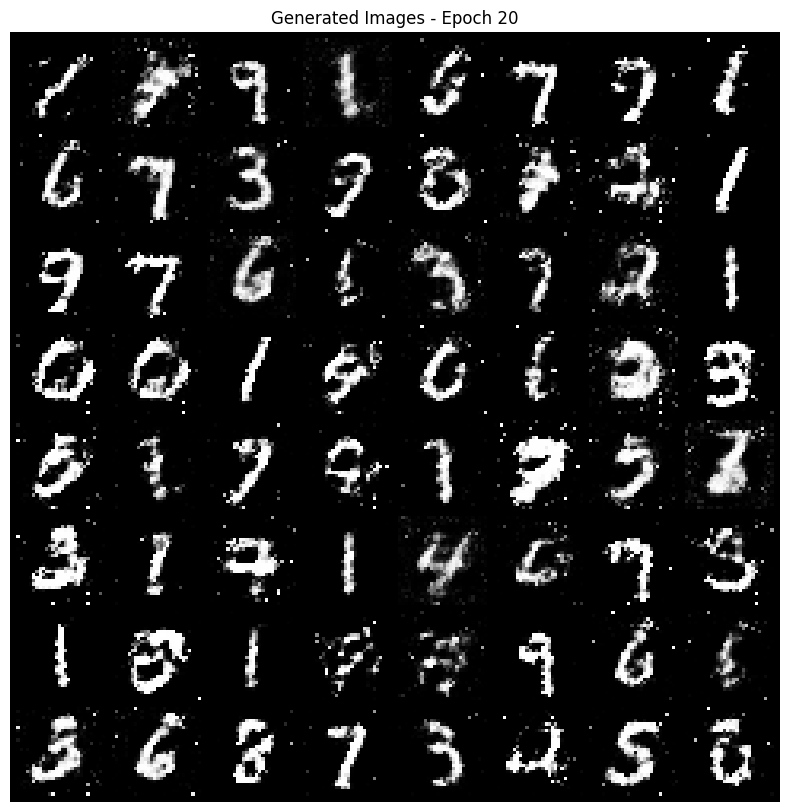

[21/50][0/469] D_loss: 1.0559 G_loss: 1.2763 D(x): 0.6243 D(G(z)): 0.3334
[21/50][100/469] D_loss: 0.9936 G_loss: 1.4713 D(x): 0.7254 D(G(z)): 0.2707
[21/50][200/469] D_loss: 0.9737 G_loss: 1.3402 D(x): 0.6508 D(G(z)): 0.3009
[21/50][300/469] D_loss: 0.9958 G_loss: 1.7362 D(x): 0.7479 D(G(z)): 0.2074
[21/50][400/469] D_loss: 1.1293 G_loss: 1.0678 D(x): 0.5743 D(G(z)): 0.3743
[22/50][0/469] D_loss: 1.0768 G_loss: 1.5775 D(x): 0.6730 D(G(z)): 0.2528
[22/50][100/469] D_loss: 0.9262 G_loss: 1.4426 D(x): 0.7652 D(G(z)): 0.2597
[22/50][200/469] D_loss: 0.9563 G_loss: 1.2712 D(x): 0.6217 D(G(z)): 0.3255
[22/50][300/469] D_loss: 1.0840 G_loss: 1.1718 D(x): 0.5676 D(G(z)): 0.3491
[22/50][400/469] D_loss: 1.0536 G_loss: 1.4830 D(x): 0.5779 D(G(z)): 0.2716
[23/50][0/469] D_loss: 1.0526 G_loss: 1.6380 D(x): 0.6824 D(G(z)): 0.2373
[23/50][100/469] D_loss: 0.9933 G_loss: 1.5099 D(x): 0.6713 D(G(z)): 0.2559
[23/50][200/469] D_loss: 1.0399 G_loss: 1.2956 D(x): 0.6313 D(G(z)): 0.3222
[23/50][300/469] D

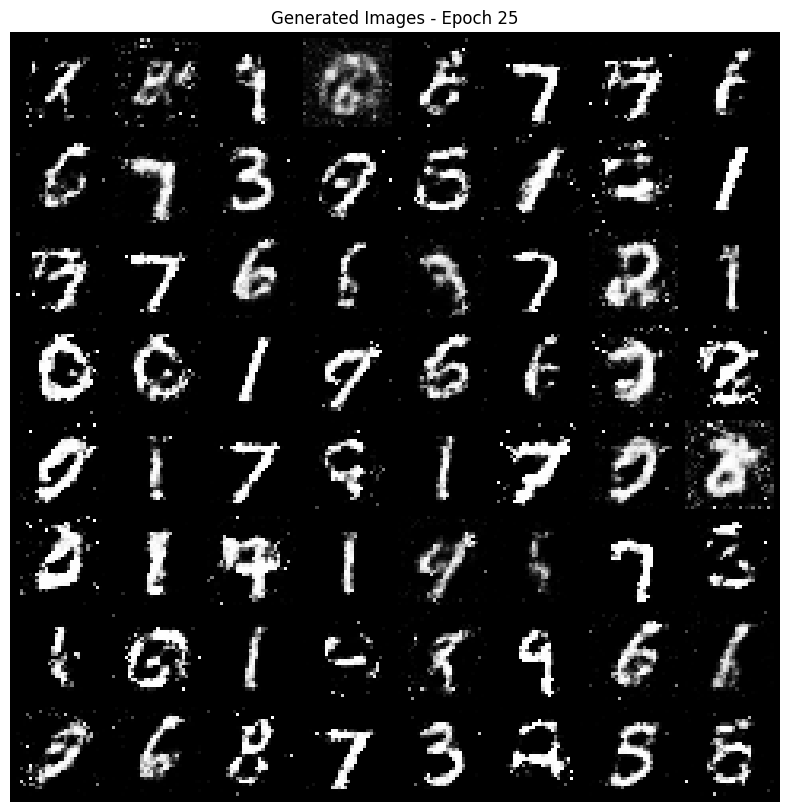

[26/50][0/469] D_loss: 1.0004 G_loss: 1.1292 D(x): 0.6525 D(G(z)): 0.3695
[26/50][100/469] D_loss: 1.0305 G_loss: 1.1453 D(x): 0.6026 D(G(z)): 0.3584
[26/50][200/469] D_loss: 1.0565 G_loss: 1.2304 D(x): 0.6515 D(G(z)): 0.3394
[26/50][300/469] D_loss: 1.0320 G_loss: 1.7436 D(x): 0.7435 D(G(z)): 0.2116
[26/50][400/469] D_loss: 1.1678 G_loss: 1.2886 D(x): 0.5585 D(G(z)): 0.3056
[27/50][0/469] D_loss: 0.9124 G_loss: 1.2064 D(x): 0.6766 D(G(z)): 0.3408
[27/50][100/469] D_loss: 1.0814 G_loss: 1.3935 D(x): 0.7636 D(G(z)): 0.2868
[27/50][200/469] D_loss: 1.0475 G_loss: 1.5970 D(x): 0.7028 D(G(z)): 0.2357
[27/50][300/469] D_loss: 0.9655 G_loss: 1.1585 D(x): 0.6140 D(G(z)): 0.3489
[27/50][400/469] D_loss: 1.0570 G_loss: 1.0754 D(x): 0.6128 D(G(z)): 0.3845
[28/50][0/469] D_loss: 0.9601 G_loss: 1.2752 D(x): 0.6823 D(G(z)): 0.3145
[28/50][100/469] D_loss: 1.0225 G_loss: 1.0468 D(x): 0.6236 D(G(z)): 0.4108
[28/50][200/469] D_loss: 1.0284 G_loss: 1.0011 D(x): 0.5587 D(G(z)): 0.4173
[28/50][300/469] D

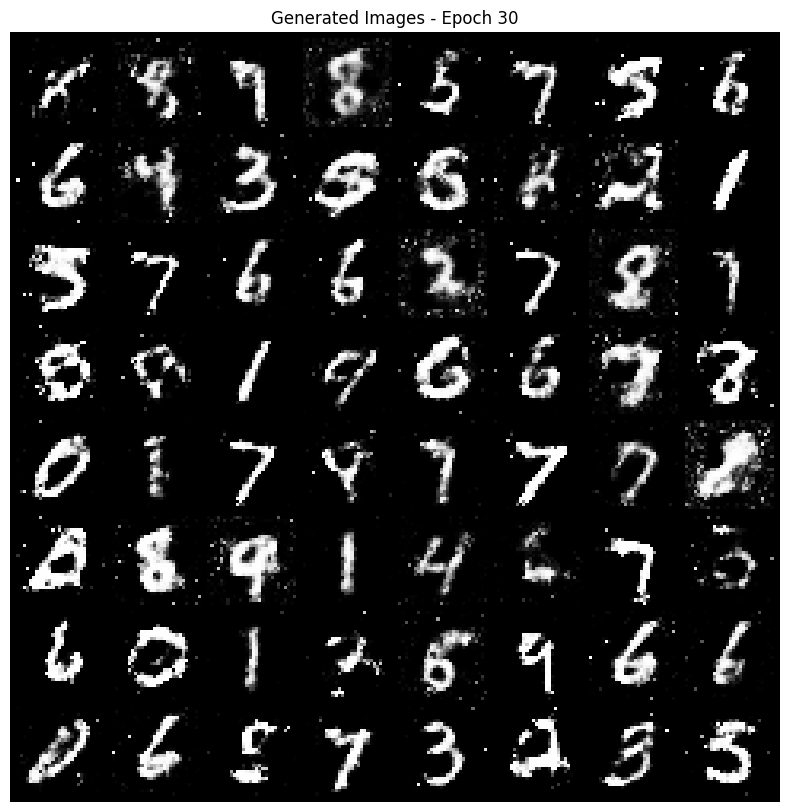

[31/50][0/469] D_loss: 1.0009 G_loss: 1.2232 D(x): 0.7030 D(G(z)): 0.3312
[31/50][100/469] D_loss: 1.0289 G_loss: 1.2371 D(x): 0.6083 D(G(z)): 0.3378
[31/50][200/469] D_loss: 1.0041 G_loss: 1.0607 D(x): 0.6085 D(G(z)): 0.3914
[31/50][300/469] D_loss: 1.0981 G_loss: 1.5828 D(x): 0.7389 D(G(z)): 0.2413
[31/50][400/469] D_loss: 1.0055 G_loss: 1.6262 D(x): 0.6938 D(G(z)): 0.2446
[32/50][0/469] D_loss: 1.0196 G_loss: 1.1455 D(x): 0.6975 D(G(z)): 0.3681
[32/50][100/469] D_loss: 1.0565 G_loss: 1.5154 D(x): 0.7142 D(G(z)): 0.2655
[32/50][200/469] D_loss: 0.9886 G_loss: 1.1328 D(x): 0.6179 D(G(z)): 0.3748
[32/50][300/469] D_loss: 1.0515 G_loss: 1.3242 D(x): 0.6625 D(G(z)): 0.3106
[32/50][400/469] D_loss: 1.1202 G_loss: 0.8524 D(x): 0.5021 D(G(z)): 0.4690
[33/50][0/469] D_loss: 0.9799 G_loss: 1.2668 D(x): 0.6417 D(G(z)): 0.3384
[33/50][100/469] D_loss: 0.9134 G_loss: 0.8695 D(x): 0.6701 D(G(z)): 0.4617
[33/50][200/469] D_loss: 1.0382 G_loss: 1.3612 D(x): 0.5991 D(G(z)): 0.2933
[33/50][300/469] D

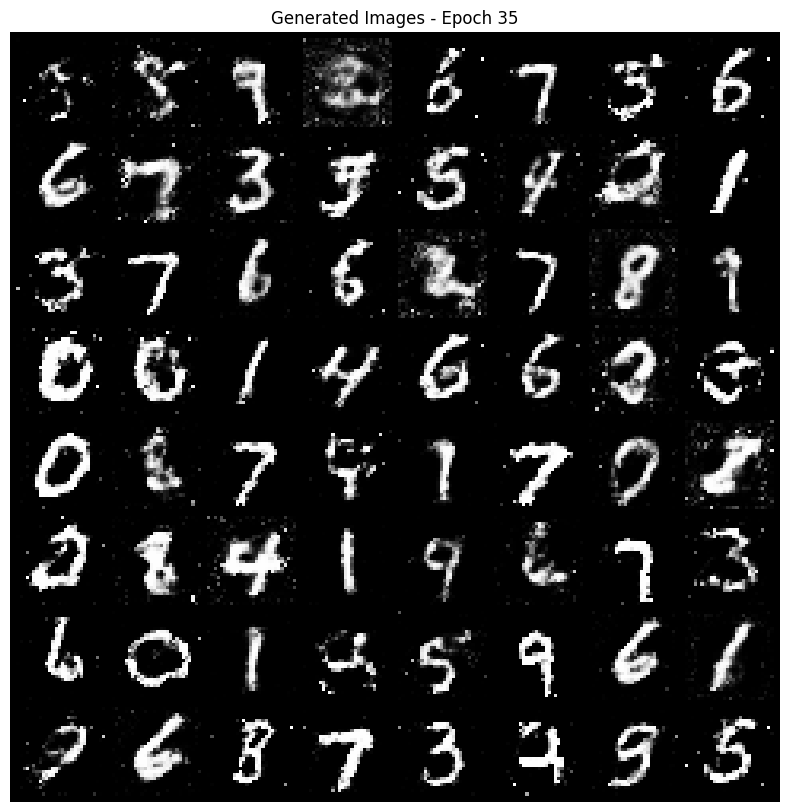

[36/50][0/469] D_loss: 0.9905 G_loss: 1.4190 D(x): 0.6568 D(G(z)): 0.2828
[36/50][100/469] D_loss: 1.0474 G_loss: 1.4666 D(x): 0.7349 D(G(z)): 0.2606
[36/50][200/469] D_loss: 0.9944 G_loss: 1.1617 D(x): 0.6407 D(G(z)): 0.3649
[36/50][300/469] D_loss: 1.0018 G_loss: 1.1790 D(x): 0.6309 D(G(z)): 0.3497
[36/50][400/469] D_loss: 1.0860 G_loss: 1.3566 D(x): 0.7019 D(G(z)): 0.3045
[37/50][0/469] D_loss: 1.0760 G_loss: 1.1579 D(x): 0.5820 D(G(z)): 0.3541
[37/50][100/469] D_loss: 1.0561 G_loss: 1.1068 D(x): 0.6019 D(G(z)): 0.3724
[37/50][200/469] D_loss: 0.9562 G_loss: 1.2823 D(x): 0.6400 D(G(z)): 0.3309
[37/50][300/469] D_loss: 1.0827 G_loss: 1.5400 D(x): 0.7021 D(G(z)): 0.2505
[37/50][400/469] D_loss: 1.0612 G_loss: 1.2457 D(x): 0.6493 D(G(z)): 0.3314
[38/50][0/469] D_loss: 1.0885 G_loss: 1.2325 D(x): 0.6360 D(G(z)): 0.3373
[38/50][100/469] D_loss: 1.0059 G_loss: 1.5915 D(x): 0.7292 D(G(z)): 0.2542
[38/50][200/469] D_loss: 0.9781 G_loss: 1.3082 D(x): 0.6893 D(G(z)): 0.3090
[38/50][300/469] D

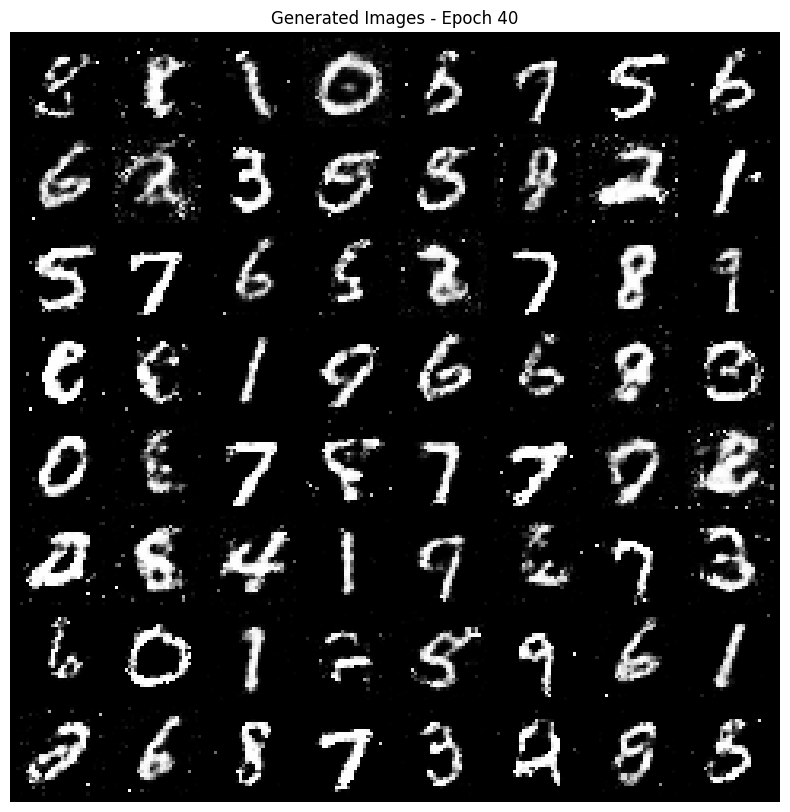

[41/50][0/469] D_loss: 0.9635 G_loss: 1.1215 D(x): 0.6637 D(G(z)): 0.3696
[41/50][100/469] D_loss: 0.9482 G_loss: 1.1980 D(x): 0.6922 D(G(z)): 0.3387
[41/50][200/469] D_loss: 0.9376 G_loss: 1.2209 D(x): 0.6735 D(G(z)): 0.3486
[41/50][300/469] D_loss: 1.0319 G_loss: 1.2652 D(x): 0.6671 D(G(z)): 0.3358
[41/50][400/469] D_loss: 0.9863 G_loss: 1.1719 D(x): 0.6729 D(G(z)): 0.3466
[42/50][0/469] D_loss: 1.0613 G_loss: 1.1743 D(x): 0.6472 D(G(z)): 0.3479
[42/50][100/469] D_loss: 1.0880 G_loss: 1.3060 D(x): 0.6397 D(G(z)): 0.3194
[42/50][200/469] D_loss: 1.0404 G_loss: 1.1128 D(x): 0.6299 D(G(z)): 0.3648
[42/50][300/469] D_loss: 1.0782 G_loss: 1.0008 D(x): 0.6120 D(G(z)): 0.4205
[42/50][400/469] D_loss: 1.0724 G_loss: 0.8623 D(x): 0.5348 D(G(z)): 0.4761
[43/50][0/469] D_loss: 1.0030 G_loss: 1.0444 D(x): 0.6067 D(G(z)): 0.4027
[43/50][100/469] D_loss: 1.0411 G_loss: 1.1927 D(x): 0.5944 D(G(z)): 0.3501
[43/50][200/469] D_loss: 1.1447 G_loss: 1.0186 D(x): 0.6005 D(G(z)): 0.4125
[43/50][300/469] D

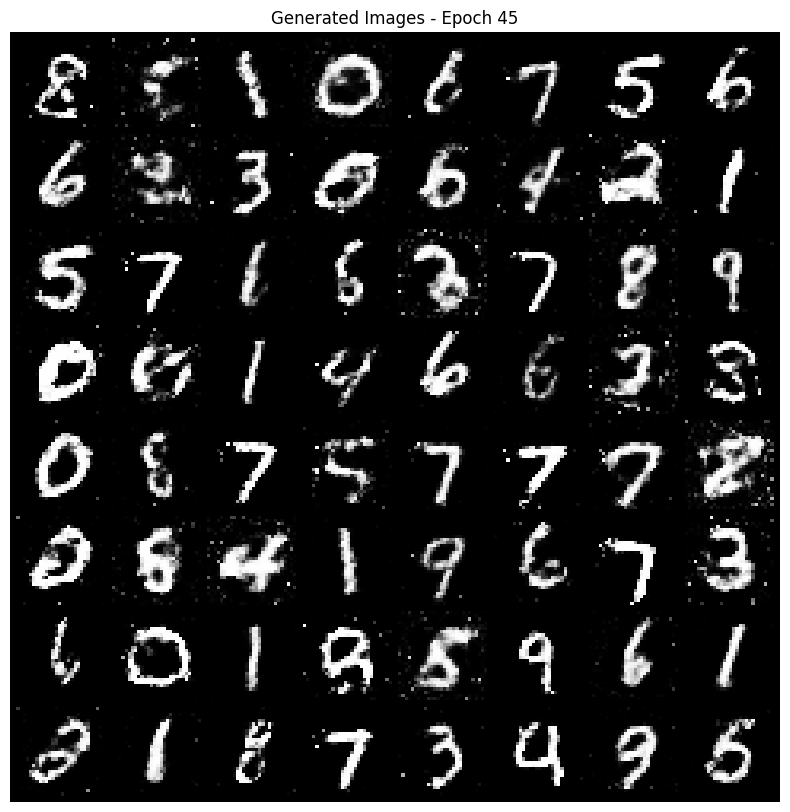

[46/50][0/469] D_loss: 1.0772 G_loss: 1.4444 D(x): 0.6313 D(G(z)): 0.2783
[46/50][100/469] D_loss: 1.0016 G_loss: 1.2955 D(x): 0.6836 D(G(z)): 0.3124
[46/50][200/469] D_loss: 0.9767 G_loss: 1.3286 D(x): 0.7209 D(G(z)): 0.3190
[46/50][300/469] D_loss: 0.9986 G_loss: 1.2767 D(x): 0.6194 D(G(z)): 0.3265
[46/50][400/469] D_loss: 1.0523 G_loss: 1.2372 D(x): 0.5962 D(G(z)): 0.3408
[47/50][0/469] D_loss: 1.1089 G_loss: 1.1296 D(x): 0.6567 D(G(z)): 0.3586
[47/50][100/469] D_loss: 1.0340 G_loss: 1.0896 D(x): 0.6369 D(G(z)): 0.3936
[47/50][200/469] D_loss: 1.1385 G_loss: 1.4781 D(x): 0.7303 D(G(z)): 0.2683
[47/50][300/469] D_loss: 1.0476 G_loss: 1.6830 D(x): 0.7601 D(G(z)): 0.2223
[47/50][400/469] D_loss: 0.9825 G_loss: 1.0956 D(x): 0.6388 D(G(z)): 0.3829
[48/50][0/469] D_loss: 0.9915 G_loss: 1.1097 D(x): 0.6483 D(G(z)): 0.3809
[48/50][100/469] D_loss: 1.0175 G_loss: 1.0640 D(x): 0.6184 D(G(z)): 0.4054
[48/50][200/469] D_loss: 1.0939 G_loss: 1.3459 D(x): 0.6421 D(G(z)): 0.2948
[48/50][300/469] D

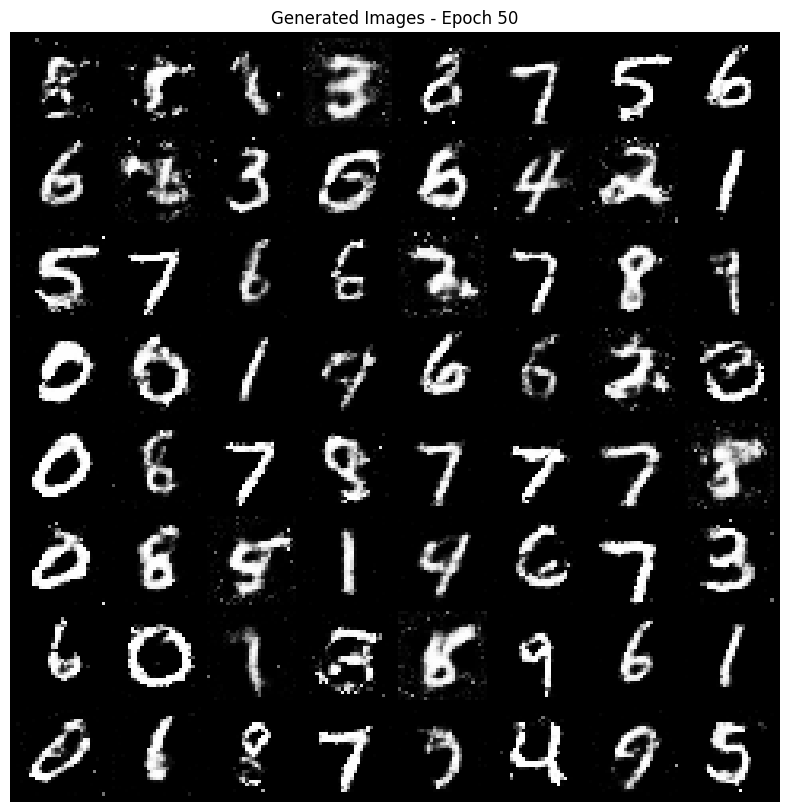


GAN TRAINING COMPLETE

Final generated images:


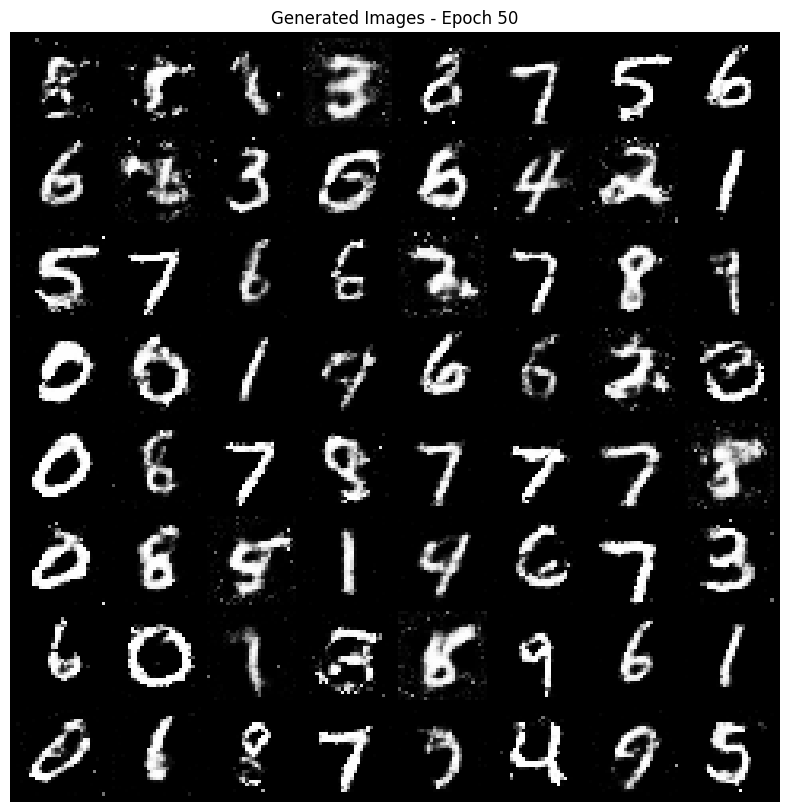


Training progress:


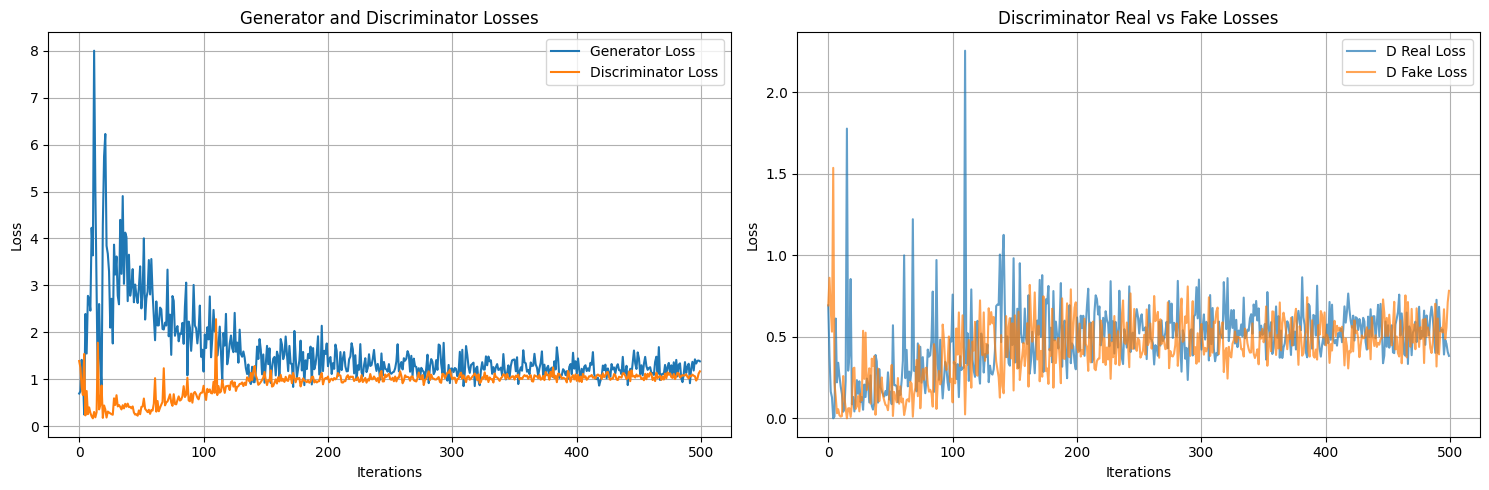


Real vs Generated images comparison:


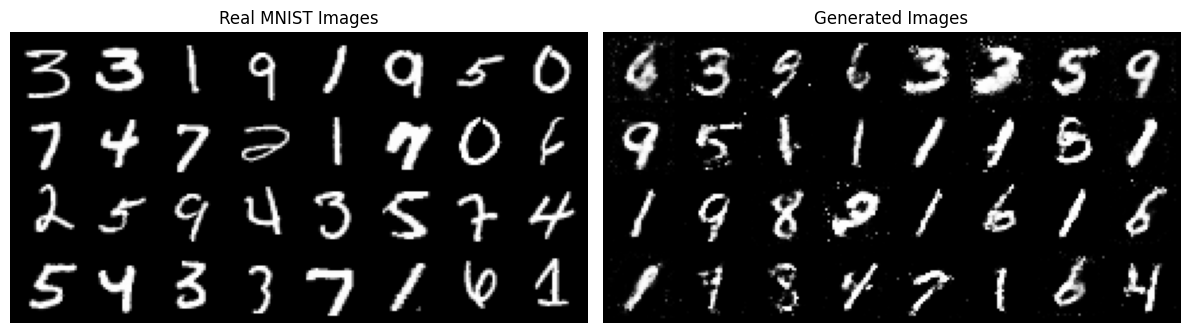


Latent space interpolation:


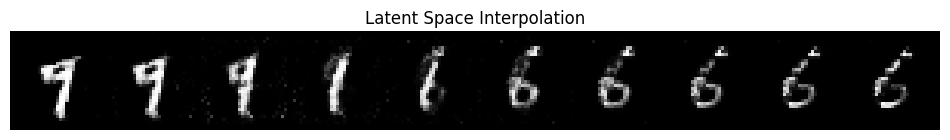

In [12]:
# Training loop
print("Starting GAN training...")
print("Generator architecture:")
print(generator)
print("\nDiscriminator architecture:")
print(discriminator)

for epoch in range(1, epochs + 1):
    train_gan(epoch)
    
    # Generate sample images every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        print(f"\nGenerating sample images at epoch {epoch}...")
        generate_images(epoch)

# Final results
print("\n" + "="*60)
print("GAN TRAINING COMPLETE")
print("="*60)

# Show final generated images
print("\nFinal generated images:")
final_images = generate_images(epochs)

# Show training progress
print("\nTraining progress:")
plot_training_progress()

# Show real vs fake comparison
print("\nReal vs Generated images comparison:")
show_real_vs_fake()

# Show latent space interpolation
print("\nLatent space interpolation:")
show_latent_interpolation()


Generating multiple samples...


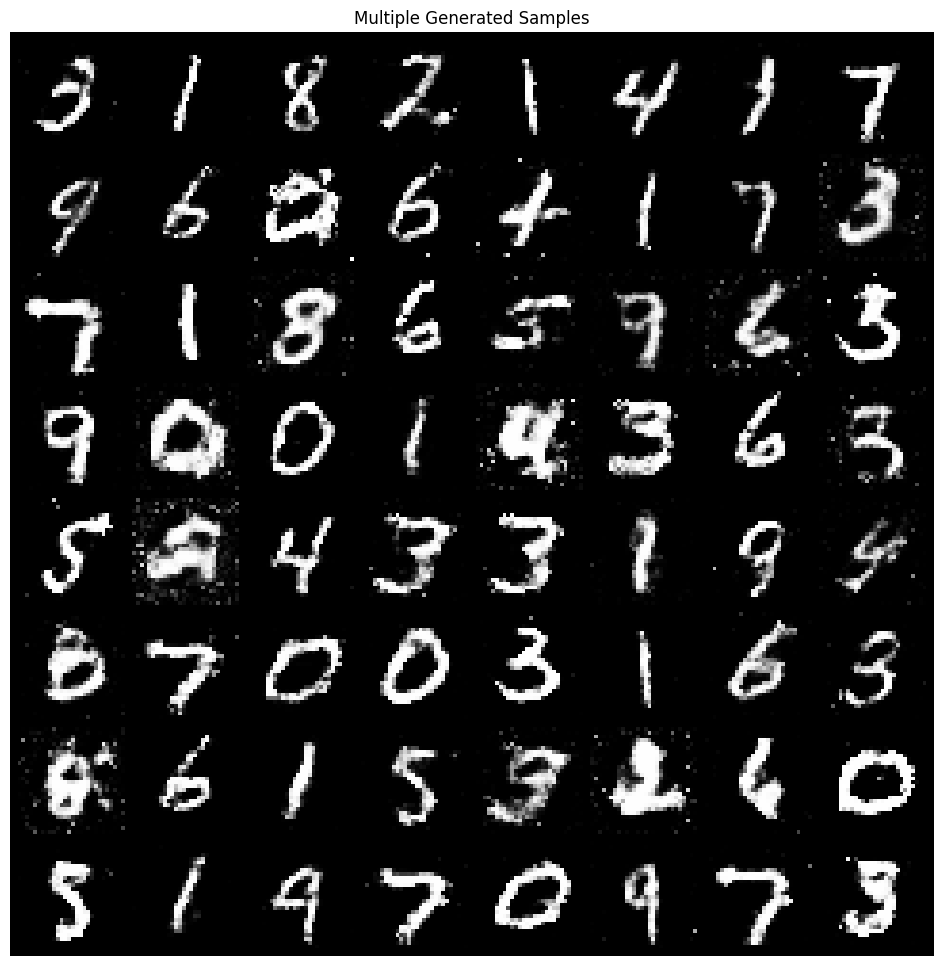


Models saved as 'gan_generator.pth' and 'gan_discriminator.pth'

Final Statistics:
Total generator iterations: 500
Final generator loss: 1.3798
Final discriminator loss: 1.1661
Training completed on: cpu


In [13]:
# Function to generate multiple samples
def generate_multiple_samples(num_samples=64):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, device=device)
        fake_images = generator(noise).detach().cpu()
        fake_images = (fake_images + 1) / 2  # Denormalize
        
        grid = make_grid(fake_images, nrow=8, normalize=False)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.title('Multiple Generated Samples')
        plt.axis('off')
        plt.show()
        
        return fake_images

# Generate multiple samples
print("\nGenerating multiple samples...")
generated_samples = generate_multiple_samples(64)

# Save model
torch.save(generator.state_dict(), 'gan_generator.pth')
torch.save(discriminator.state_dict(), 'gan_discriminator.pth')
print("\nModels saved as 'gan_generator.pth' and 'gan_discriminator.pth'")

# Print final statistics
print(f"\nFinal Statistics:")
print(f"Total generator iterations: {len(G_losses)}")
print(f"Final generator loss: {G_losses[-1]:.4f}")
print(f"Final discriminator loss: {D_losses[-1]:.4f}")
print(f"Training completed on: {device}")


TRAINING EVOLUTION DEMONSTRATION


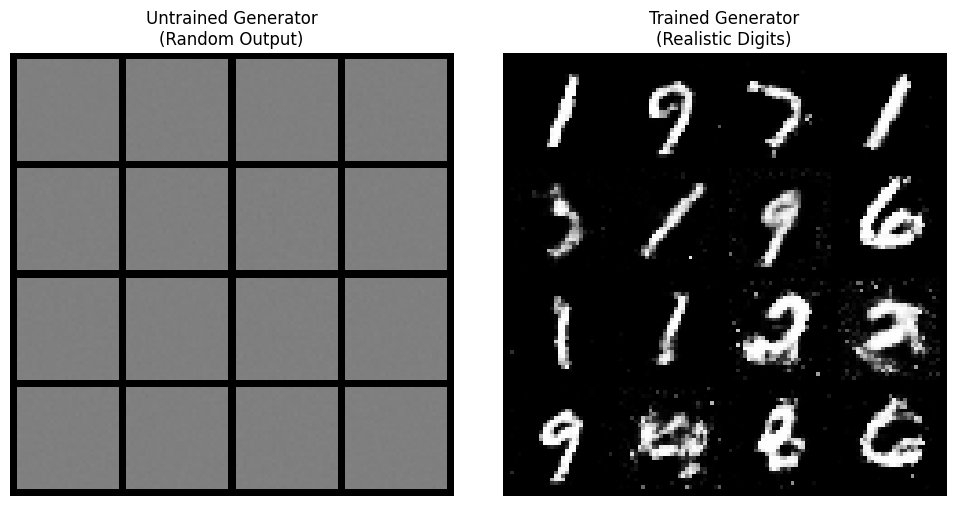

In [14]:
# Additional demonstration: Show evolution of generated images
def show_training_evolution():
    print("\n" + "="*50)
    print("TRAINING EVOLUTION DEMONSTRATION")
    print("="*50)
    
    # Create a new generator and show how images improve with training
    test_generator = Generator(latent_dim).to(device)
    test_generator.apply(weights_init)
    
    # Generate with untrained generator
    with torch.no_grad():
        noise = torch.randn(16, latent_dim, device=device)
        untrained_imgs = test_generator(noise).detach().cpu()
        untrained_imgs = (untrained_imgs + 1) / 2
    
    # Compare with trained generator
    with torch.no_grad():
        trained_imgs = generator(noise).detach().cpu()
        trained_imgs = (trained_imgs + 1) / 2
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    untrained_grid = make_grid(untrained_imgs, nrow=4, normalize=False)
    trained_grid = make_grid(trained_imgs, nrow=4, normalize=False)
    
    ax1.imshow(untrained_grid.permute(1, 2, 0), cmap='gray')
    ax1.set_title('Untrained Generator\n(Random Output)')
    ax1.axis('off')
    
    ax2.imshow(trained_grid.permute(1, 2, 0), cmap='gray')
    ax2.set_title('Trained Generator\n(Realistic Digits)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

show_training_evolution()


FINAL DEMONSTRATION: GAN IMAGE GENERATION
Key points to present during defense:
✓ The generator takes random noise (100-dimensional vector) as input
✓ It transforms this noise into realistic 28x28 digit images
✓ The discriminator learns to distinguish real from fake images
✓ Two separate optimizers train the networks adversarially
✓ No labels are used - purely unsupervised learning
✓ The generated images show the model learned the MNIST data distribution

Final generated images demonstration:


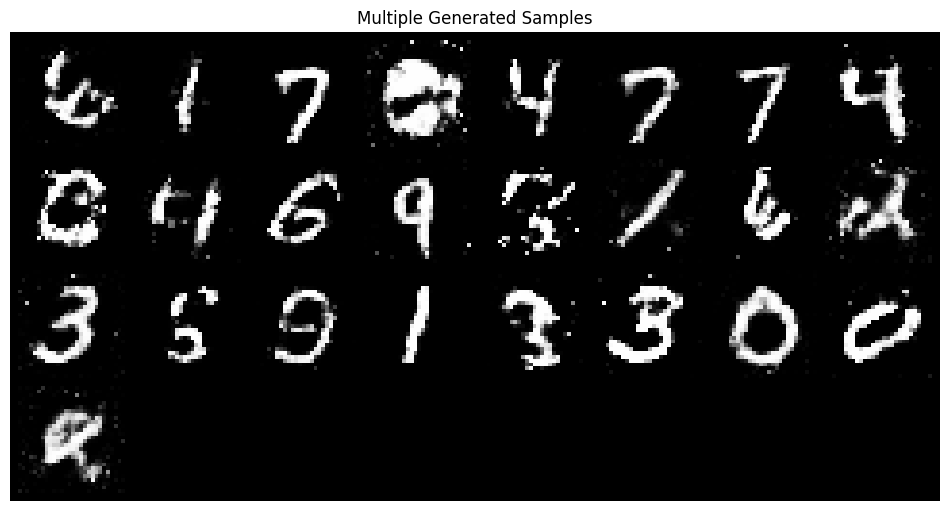

In [15]:
# Final demonstration
def demonstrate_generation():
    print("\n" + "="*50)
    print("FINAL DEMONSTRATION: GAN IMAGE GENERATION")
    print("="*50)
    
    print("Key points to present during defense:")
    print("✓ The generator takes random noise (100-dimensional vector) as input")
    print("✓ It transforms this noise into realistic 28x28 digit images")
    print("✓ The discriminator learns to distinguish real from fake images")
    print("✓ Two separate optimizers train the networks adversarially")
    print("✓ No labels are used - purely unsupervised learning")
    print("✓ The generated images show the model learned the MNIST data distribution")
    
    # Generate one final impressive set
    print("\nFinal generated images demonstration:")
    generate_multiple_samples(25)

demonstrate_generation()